In [1]:
import json
import re
from textblob import Word
from typing import List
import pandas as pd
import numpy as np

import multiprocessing; cores = multiprocessing.cpu_count() # Count the number of cores in a computer

from my_functions import get_cat, review_len, convert_category, decontracted, preprocess

In [2]:
data_file = open("./archive/yelp_academic_dataset_business.json",errors = 'ignore', encoding='utf-8')
data = []
for line in data_file:
    data.append(json.loads(line))
    
business_df = pd.DataFrame(data)
data_file.close()

In [3]:
business_df.shape

(150346, 14)

In [4]:
# Replace NoneType in categories column with ""
business_df.categories = business_df.categories.apply(lambda x: x if x is not None else "")

In [5]:
# Split string by comma to get list of tags
tokens = business_df.categories.str.split(", ")

In [6]:
# Apply convert function 
token_list = [convert_category(t) for t in tokens]

In [7]:
token_list[:2]

[['doctor',
  'traditional_chinese_medicine',
  'naturopathic_holistic',
  'acupuncture',
  'health_medical',
  'nutritionist'],
 ['shipping_center',
  'local_service',
  'notary',
  'mailbox_center',
  'printing_service']]

In [8]:
# flatten list of lists for Tfidf vectorizer
token_list2 = [" ".join(x) for x in token_list]
token_list2[:2]

['doctor traditional_chinese_medicine naturopathic_holistic acupuncture health_medical nutritionist',
 'shipping_center local_service notary mailbox_center printing_service']

In [9]:
yelp_cat = ['active_life', 'arts_entertainment', 'automotive', 'beauty_spa', 'education',
            'event_planning_service', 'financial_service', 'food', 'health_medical',
            'home_service', 'hotels_travel', 'local_flavor', 'local_service',
            'mass_media', 'night_life', 'professional_service', 'public_services_government',
            'real_estate', 'religious_organization', 'restaurant', 'shopping']        

In [10]:
business_df['categories_list'] = pd.Series(token_list2).map(lambda x: x)

In [11]:
business_df['categories_list'] = [x.split(" ") for x in business_df['categories_list']]

In [12]:
business_df['yelp_cat'] = business_df['categories_list'].apply(lambda x: get_cat(x, yelp_cat))

In [13]:
business_count = business_df.yelp_cat.value_counts().reset_index()

In [14]:
business_count['cat'] = business_count['index'].apply(lambda x: x[0])

# Read in review content

In [15]:
data_file = open("./archive/yelp_academic_dataset_review.json",errors = 'ignore', encoding='utf-8')
data = []
for line in data_file:
    data.append(json.loads(line))
    
review_df = pd.DataFrame(data)
data_file.close()

In [16]:
review_df.shape

(6990280, 9)

# Join

In [17]:
review_df = review_df.merge(business_df, how = 'left', on = 'business_id')

In [18]:
review_df = review_df.rename(columns={"stars_x": "review_rating", "stars_y": "business_rating"})

In [19]:
review_df.yelp_cat.value_counts()

(restaurant, 19)                    3790571
(food, 7)                            983876
(shopping, 20)                       318972
(beauty_spa, 3)                      301031
(event_planning_service, 5)          250722
(automotive, 2)                      204688
(arts_entertainment, 1)              166894
(hotels_travel, 10)                  160006
(health_medical, 8)                  143858
(home_service, 9)                    142275
(active_life, 0)                     131073
(local_service, 12)                  112217
(local_flavor, 11)                    49297
(professional_service, 15)            27429
(real_estate, 17)                     23755
(public_services_government, 16)      19736
(education, 4)                        15921
(financial_service, 6)                14553
(religious_organization, 18)           3416
Name: yelp_cat, dtype: int64

In [20]:
review_df['cat'] =   review_df['yelp_cat'].str[0]

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

# train, test
train, test = train_test_split(review_df, test_size=0.25, random_state=42)

# split train into train and val
val, test = train_test_split(test, test_size = 0.40, random_state=42 )

In [22]:
print(train.shape, val.shape, test.shape)

(5242710, 25) (1048542, 25) (699028, 25)


In [23]:
train.columns

Index(['review_id', 'user_id', 'business_id', 'review_rating', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_rating',
       'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'categories_list', 'yelp_cat', 'cat'],
      dtype='object')

# EDA

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

## Count Plot

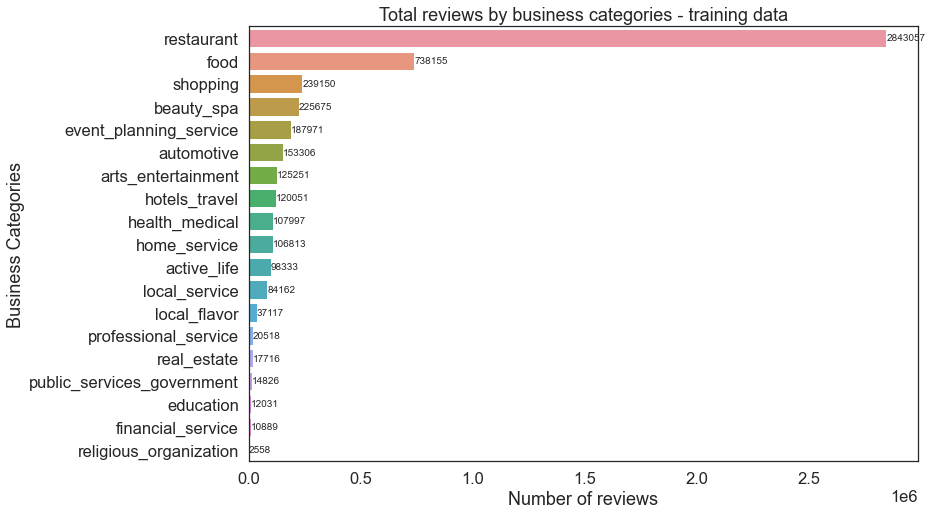

In [25]:

sns.set(style = "white",font_scale = 1.5)
plt.figure(figsize = (12,8))



ax = sns.countplot(y=train['cat'],
                   order=train['cat'].value_counts(ascending=False).index);

abs_values = train['cat'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)


plt.ylabel("Business Categories")
plt.xlabel("Number of reviews")
plt.title("Total reviews by business categories - training data")
plt.savefig("./figs/reviews_business_categories.png",bbox_inches="tight", transparent=True)

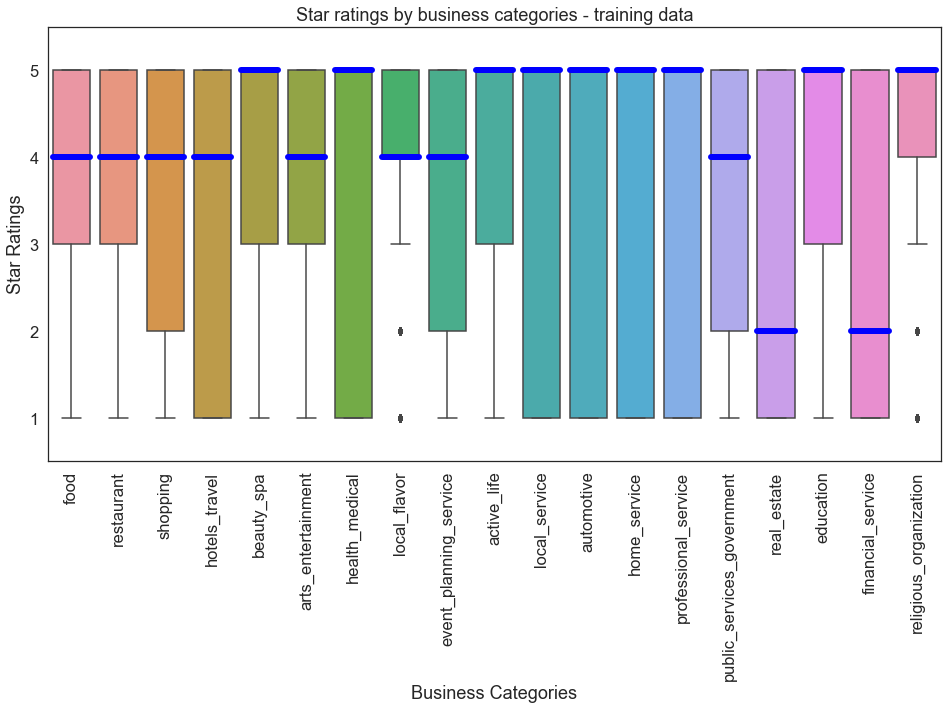

In [26]:

sns.set(style = "white",font_scale = 1.5)
plt.figure(figsize = (16,8))
ax = sns.boxplot(x="cat", y="review_rating", data=train,medianprops={'color':'blue','ls': '-', 'lw': 6})
ax.set_ylim(0.5,5.5)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.xlabel("Business Categories")
plt.ylabel("Star Ratings")
plt.title("Star ratings by business categories - training data")
plt.savefig("./figs/star_ratings_business_categories.png",bbox_inches="tight", transparent=True)

In [27]:
train.groupby("cat")['review_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
cat,,,,,,,,
active_life,98333.0,3.932566,1.428864,1.0,3.0,5.0,5.0,5.0
arts_entertainment,125251.0,3.822884,1.374501,1.0,3.0,4.0,5.0,5.0
automotive,153306.0,3.368779,1.829525,1.0,1.0,5.0,5.0,5.0
beauty_spa,225675.0,3.875467,1.603277,1.0,3.0,5.0,5.0,5.0
education,12031.0,3.941235,1.515601,1.0,3.0,5.0,5.0,5.0
event_planning_service,187971.0,3.642221,1.499376,1.0,2.0,4.0,5.0,5.0
financial_service,10889.0,2.667003,1.817403,1.0,1.0,2.0,5.0,5.0
food,738155.0,3.906265,1.361871,1.0,3.0,4.0,5.0,5.0
health_medical,107997.0,3.540830,1.790448,1.0,1.0,5.0,5.0,5.0


In [32]:
business_rating = train.groupby(["cat","business_rating"]).size().reset_index()

# Review length


In [28]:
train['text_len'] = train.text.apply(lambda x: review_len(x))

In [46]:
train.groupby('cat')['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
cat,,,,,,,,
active_life,98333.0,119.578290,108.754856,1.0,49.0,87.0,153.0,1013.0
arts_entertainment,125251.0,114.301219,104.945874,1.0,46.0,83.0,147.0,1002.0
automotive,153306.0,120.085665,116.543518,1.0,47.0,84.0,149.0,1059.0
beauty_spa,225675.0,103.683323,95.857219,1.0,43.0,75.0,130.0,1021.0
education,12031.0,130.658299,121.653256,1.0,53.0,94.0,163.0,951.0
event_planning_service,187971.0,120.220598,110.781909,1.0,48.0,87.0,153.0,1002.0
financial_service,10889.0,118.213794,110.507840,3.0,48.0,85.0,149.0,1004.0
food,738155.0,96.832675,87.595130,1.0,39.0,70.0,124.0,997.0
health_medical,107997.0,124.228303,117.044269,1.0,50.0,89.0,155.0,1019.0


In [50]:
train[train.text_len >= 900].review_rating.value_counts()

1.0    1578
2.0     387
5.0     350
3.0     270
4.0     237
Name: review_rating, dtype: int64

# Save data

In [47]:
train.to_csv("./data/train.csv", index = False)
val.to_csv("./data/val.csv", index = False)
test.to_csv("./data/test.csv", index = False)

# Top words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


# 2: create dtm
# custom_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
#                                     strip_accents = 'unicode',
#                                     lowercase=True)
custom_vectorizer = CountVectorizer()
# fit on review column
X = custom_vectorizer.fit_transform(train["clean_text"])

In [ ]:
# list of tokens
word_list = custom_vectorizer.get_feature_names()
# sum the sparse array, reshape to get a 1-D array
count_list = np.asarray(X.sum(axis=0)).reshape(-1,).tolist()
# Word frequency
word_freq = dict(zip(word_list, count_list))


In [ ]:
# Most common words
from collections import Counter
dict(Counter(word_freq).most_common(50)).keys()

In [ ]:
top_50 = pd.Series(dict(Counter(word_freq).most_common(50)).keys(), name = 'token')

In [ ]:
top_50